<a href="https://colab.research.google.com/github/akd18/DS-SL/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train_data_raw = pd.read_csv('train.csv')
test_data_raw = pd.read_csv('test.csv')

In [6]:
train_data_raw.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
89,90,0,3,"Celotti, Mr. Francesco",male,24.0,0,0,343275,8.05,NaN,S
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.00,NaN,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.55,C103,S
748,749,0,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,113773,53.10,D30,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S


In [7]:
columns_all = train_data_raw.columns
columns_all

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Exploratory Data Analysis

In [8]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- There are 891 records and there are missing values in some of the columns.

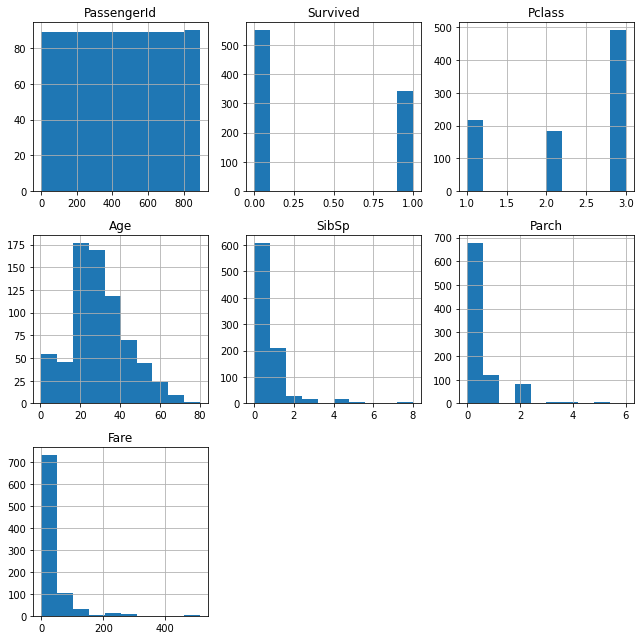

In [9]:
train_data_raw.hist(figsize=(9,9))
plt.tight_layout()

In [10]:
train_data_raw['Survived'].value_counts().apply(lambda x:f'{x} ({x*100/len(train_data_raw):0.2f}%)')

0    549 (61.62%)
1    342 (38.38%)
Name: Survived, dtype: object

Initial Inferences :

- The dataset is mildly imbalanced.
- The columns 'PassengerId' & 'Name' are unique identifiers.
- 'Survived' is the target column that we have to predict.
- The columns 'Pclass', 'Sex' and 'Embarked' are categorical columns and the rest are numerical.
- The column 'SibSp' should ideally be integer value.


We shall split our training data to train-test set before proceeding further to avoid any data leakage into test set.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_set,test_set = train_test_split(train_data_raw,test_size=0.2,stratify=train_data_raw['Survived'],random_state=21)

We shall create a copy of train_set so as to not loose the original training set during feature engineering.

In [13]:
train_original = train_set.copy()
train_set.reset_index(drop=True,inplace=True)

In [14]:
train_set.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
128,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
530,546,0,1,"Nicholson, Mr. Arthur Ernest",male,64.0,0,0,693,26.0000,NaN,S
239,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
206,622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
26,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [15]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,444.730337,0.383427,2.307584,29.806678,0.485955,0.376404,31.756120
std,259.308184,0.486563,0.831550,14.836519,1.025593,0.769609,48.467739
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,218.750000,0.000000,2.000000,20.375000,0.000000,0.000000,7.895800
50%,443.500000,0.000000,3.000000,28.000000,0.000000,0.000000,13.931250
75%,668.250000,1.000000,3.000000,39.000000,1.000000,0.000000,30.500000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
# No. of unique elements in each column
train_set.apply(lambda x: x.nunique())

PassengerId    712
Survived         2
Pclass           3
Name           712
Sex              2
Age             87
SibSp            7
Parch            7
Ticket         569
Fare           226
Cabin          119
Embarked         3
dtype: int64

In [17]:
num_cols = train_set.select_dtypes('number').columns.drop(['PassengerId','Survived','Pclass']).to_numpy()
cat_cols = list(train_set.select_dtypes('object').columns.drop(['Name']))
cat_cols.extend(['Pclass'])
print("Numerical Columns : ",num_cols)
print("Categorical Columns : ",cat_cols)

Numerical Columns :  ['Age' 'SibSp' 'Parch' 'Fare']
Categorical Columns :  ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']


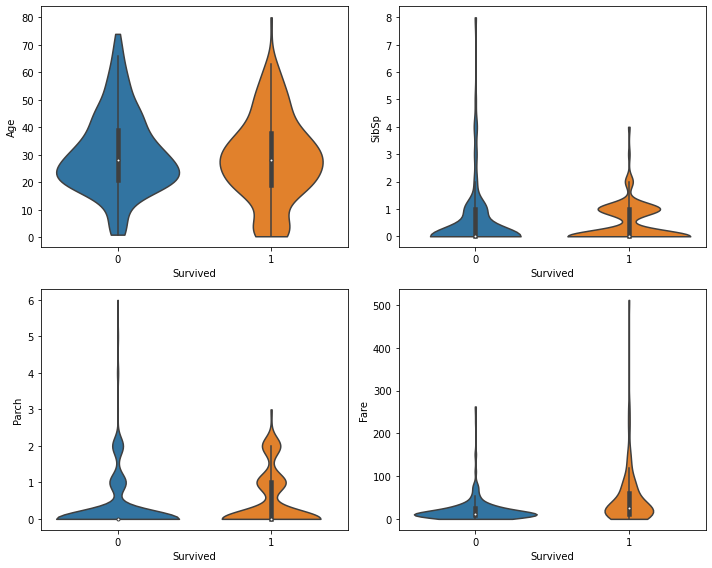

In [18]:
n_def_num_cols = len(num_cols)
fig,ax = plt.subplots(round(n_def_num_cols/2),2,figsize=(10,n_def_num_cols*2))
for i,col in enumerate(num_cols):
  sns.violinplot(x='Survived',y=col,data=train_set,ax=ax.ravel()[i],orient='v',cut=0)
fig.tight_layout()

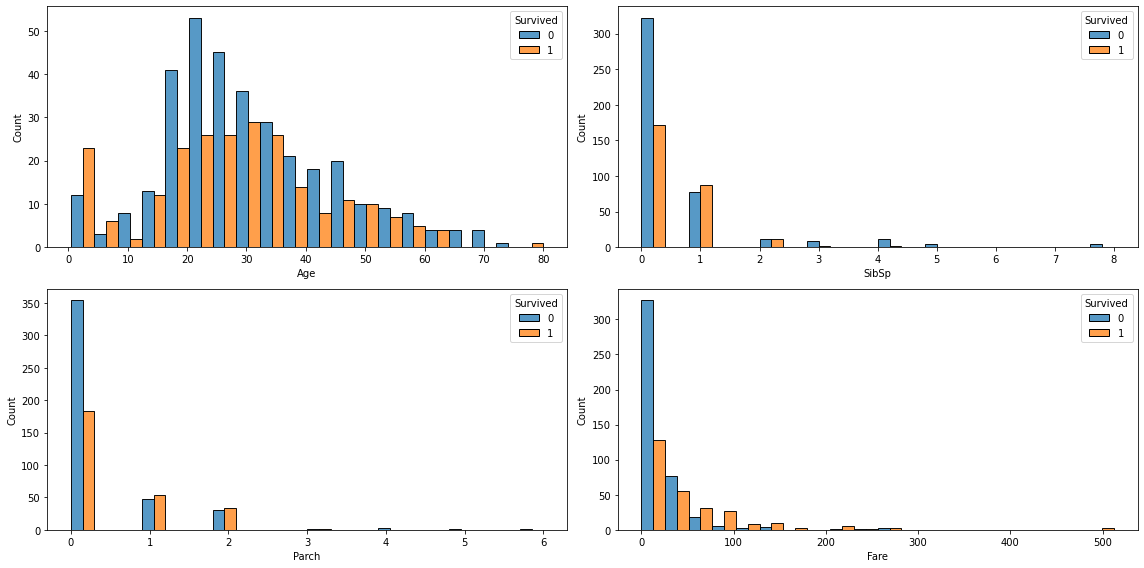

In [19]:
fig,ax = plt.subplots(round(n_def_num_cols/2),2,figsize=(16,n_def_num_cols*2))
for i,col in enumerate(num_cols):
  sns.histplot(x=col,data=train_set,hue='Survived',multiple='dodge',ax=ax.ravel()[i],bins=20,lw=1)
fig.tight_layout()

- We can see that, the survival rate is higher for the kids and elderly. The survial rate for inividuals between 20-30 is very low.
- We could also observe that the chances of survival is increasing with the price paid for the ticket.

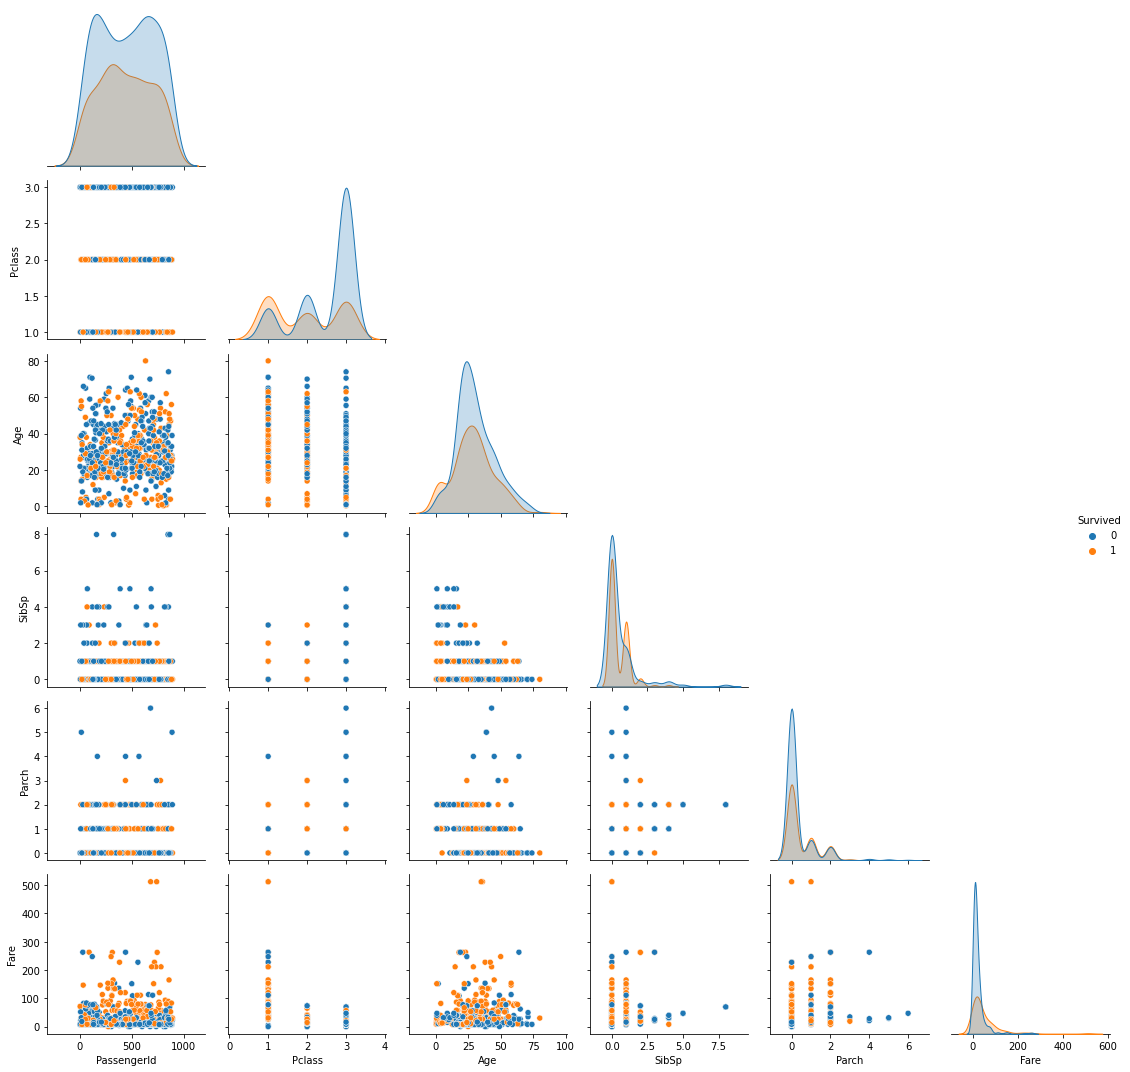

In [20]:
sns.pairplot(hue='Survived',data=train_set,corner=True)
plt.tight_layout()

- The classification of survival isnt linearly seperable with any of the feature.
- There arent any distinct correlation within various features.

In [21]:
train_corr = train_set.corr()

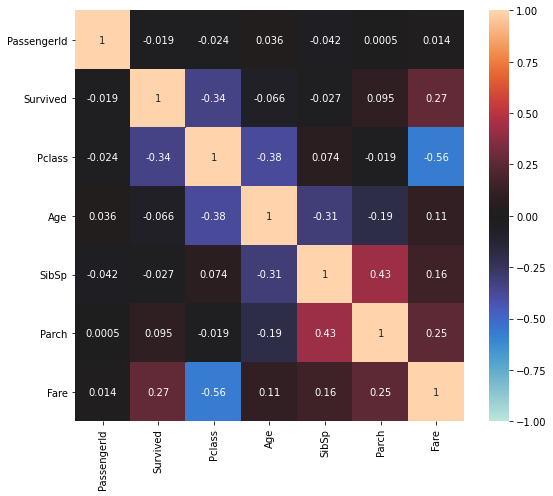

In [22]:
plt.subplots(figsize=(8,7))
sns.heatmap(train_corr,vmax=1,vmin=-1,annot=True,cmap=sns.color_palette("icefire", as_cmap=True))
plt.tight_layout()

In [23]:
print("Correlation of Features with 'Survived' \n")
train_corr.loc[:,'Survived'].sort_values(ascending=False).drop('Survived')

Correlation of Features with 'Survived' 



Fare           0.268678
Parch          0.094806
PassengerId   -0.018821
SibSp         -0.027243
Age           -0.065538
Pclass        -0.340564
Name: Survived, dtype: float64

In [24]:
print("Correlation within Features  \n")
for i,y in enumerate(train_corr.index):
    for j,x in enumerate(train_corr.columns.drop('Survived')):
        if(j<i):
            continue
        if ((train_corr.loc[x,y] >0.4) or (train_corr.loc[x,y] <-0.4)) and x!=y:
            print(f'{x} - {y}  : {train_corr.loc[x,y]}')

Correlation within Features  

Fare - Pclass  : -0.5648039044618131
Parch - SibSp  : 0.42723738370230097


- The Ticket class has the highest correlation with the target column 'Survived'
- The ticket fare and the ticket class are correlated which makes much sense.
- Also the number of siblings/spouses aboard is correlated with the number of parents/children aboard.

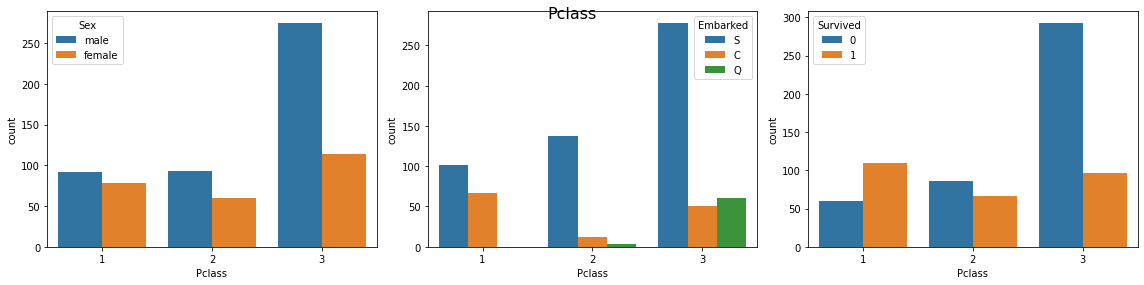

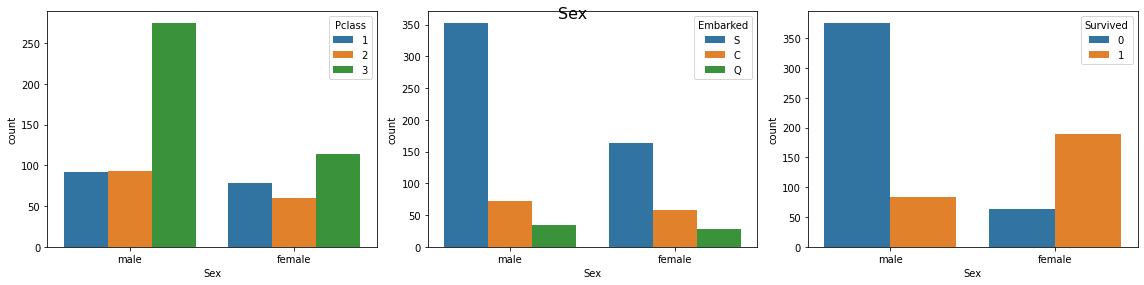

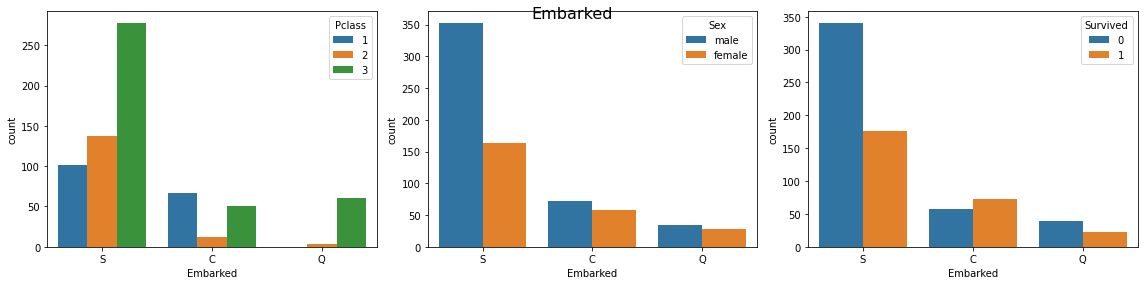

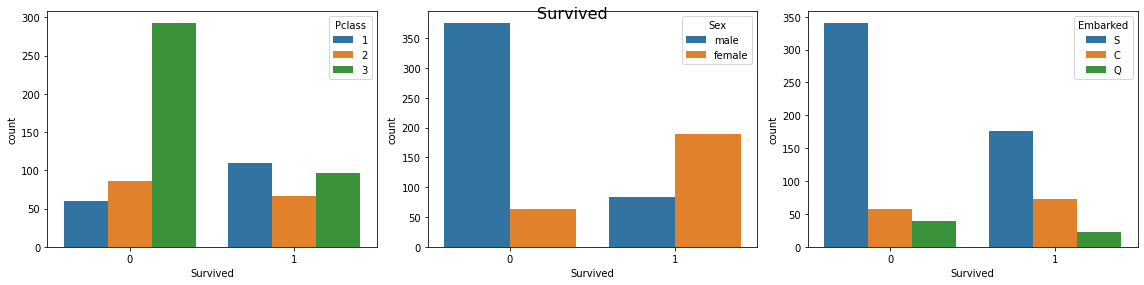

In [25]:
for i,col in enumerate(['Pclass','Sex','Embarked','Survived']):
  j=0
  fig,ax = plt.subplots(1,3,figsize=(16,4),)
  for col1 in ['Pclass','Sex','Embarked','Survived']:
    if col1!=col:    
      sns.countplot(x=col,data=train_set,hue=col1,ax=ax[j])
      j=j+1
  
  fig.suptitle(col,size=16)
  fig.tight_layout()

As we can see, some of the insights that can be drawn are
- The survival chances for females were much higher than males.
- The chances of survival  were higher for Individuals with TicketClass('Pclass')-1. Passengers with Class-1 Ticket has survived more than any other class.
- Passengers who embarked from port Cherbourg has a higher survival ratio.
- Most passengers with 1st class tickets survived and the survival rate was much higher than any other ticket class. It could also be noted that there were no 1st class passengers from Queenstown.
- Passengers embarked from Cherbourg has higher survival ratio.



In [26]:
from scipy.stats import chi2_contingency

In [27]:
alpha = 0.05
for col in cat_cols:
  cross_table = pd.crosstab(train_set[col],train_set['Survived'])
  chi2_stat,p_value, dof, exp = chi2_contingency(cross_table)
  if p_value <= alpha:
    print(f"{col}-Survived \np-value : ",p_value)
    print("Dependent (reject H0)",'\n')
  else:
    print(f"{col}-Survived \np-value : ",p_value)
    print("Independent (fail to reject H0)",'\n')

Sex-Survived 
p-value :  1.277767685540944e-49
Dependent (reject H0) 

Ticket-Survived 
p-value :  0.03529249290136183
Dependent (reject H0) 

Cabin-Survived 
p-value :  0.1860186007157923
Independent (fail to reject H0) 

Embarked-Survived 
p-value :  4.255379308445157e-05
Dependent (reject H0) 

Pclass-Survived 
p-value :  1.1461931253253146e-18
Dependent (reject H0) 



Only 'Cabin' had no relation with 'Survived' column. This could also be due to the unavailability of over 75% of the data for 'Cabin'

# Feature Engineering

In [28]:
train_set.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [29]:
# Modifying DataType
#
train_set.loc[:,cat_cols] = train_set[cat_cols].astype('category',errors='ignore')
train_set.loc[:,'PassengerId'] = train_set[['PassengerId']].astype('object',errors='ignore')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [30]:
def missing_count(data,cols=None):
  print("Number of Instances : ",len(data))
  print("Number of Missing Values in :")
  df = pd.DataFrame(data)
  if cols==None:
    cols=df.columns
  for x in cols:
    count  = df[x].isna().sum()
    if count >=1:
      print(f' - {x} : {count}({count*100/len(df):0.2f}%)')



In [31]:
missing_count(train_set)

Number of Instances :  712
Number of Missing Values in :
 - Age : 140(19.66%)
 - Cabin : 550(77.25%)
 - Embarked : 2(0.28%)


- Embarked has 2 values missing, we could remove the entry/instance since its only 2.
- Age has 140 values missing, which constitutes about 20% of the whole data. We could impute these missing values.
- Cabin has more than 75% of missing values. Ideally we should drop this feature or find some way to extract any available information if possible.

### Feature - 'Embarked '

In [32]:
train_set.dropna(subset=['Embarked'],inplace=True)
train_set.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


We shall impute the missing values in 'Age'. We had noticed that 'Pclass' had the highest correlation with 'Age', so instead of taking the median of the whole training set, we shall impute with class-wise(ticket) median age.

### Feature - 'Age'

In [33]:
pclass_avg_age = train_set.groupby(['Pclass'])['Age'].median()
pclass_avg_age

Pclass
1    38.0
2    30.0
3    24.0
Name: Age, dtype: float64

In [34]:
pd.Series(train_set.columns)

0     PassengerId
1        Survived
2          Pclass
3            Name
4             Sex
5             Age
6           SibSp
7           Parch
8          Ticket
9            Fare
10          Cabin
11       Embarked
dtype: object

In [35]:
train_set.Age = train_set.apply((lambda x: pclass_avg_age[x[8]] if np.isnan(x[0]) else x[0]),axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [36]:
missing_count(train_set)

Number of Instances :  710
Number of Missing Values in :
 - Cabin : 550(77.46%)


'Cabin' has over 77% of its values missing, dropping the column is the ideal choice. But before droping, we shall try to extract any information if possible.

### Feature - 'Cabin'

In [37]:
print("No. of Entries available : ",train_set.Cabin.notna().sum(),'\n')
train_set.Cabin.unique()

No. of Entries available :  160 



[NaN, 'C128', 'C103', 'B35', 'C22 C26', ..., 'C2', 'A26', 'D7', 'E12', 'C125']
Length: 119
Categories (118, object): ['C128', 'C103', 'B35', 'C22 C26', ..., 'A26', 'D7', 'E12', 'C125']

In [38]:
# Checking if all the values in Cabin starts with an alphabet
pd.Series([str(x)[0].isalpha() if x!=np.nan else False for x in train_set.Cabin.unique()]).sum()

119

In [39]:
# Checking if multiple people have the same cabin/s
train_set.Cabin.value_counts()

G6             4
C22 C26        3
C23 C25 C27    3
E101           3
F2             3
              ..
D28            1
D33            1
D36            1
A14            1
B28            0
Name: Cabin, Length: 119, dtype: int64

As we can see, all of 119 unique elements starts with an alphabet. We could group the Cabin codes using this initial alphabet character.

In [40]:
shared_cabins = train_set.Cabin.value_counts()[train_set.Cabin.value_counts()>1].index
shared_cabins

CategoricalIndex(['G6', 'C22 C26', 'C23 C25 C27', 'E101', 'F2', 'B96 B98',
                  'C68', 'D26', 'B49', 'B5', 'B51 B53 B55', 'D35',
                  'B57 B59 B63 B66', 'B58 B60', 'D', 'D20', 'B77', 'B20',
                  'C93', 'C92', 'C65', 'C52', 'C124', 'E121', 'C126', 'E24',
                  'E44', 'F4', 'B18', 'E25', 'F33', 'F G73', 'E33', 'E67',
                  'E8'],
                 categories=['A14', 'A16', 'A19', 'A23', 'A24', 'A26', 'A31', 'A32', ...], ordered=False, dtype='category')

In [41]:
cabins=[]
for x in train_set.Cabin.value_counts().index:
  if ' ' in x:
    cabins.extend(x.split(' '))
  else:
    cabins.append(x)
print(cabins)

['G6', 'C22', 'C26', 'C23', 'C25', 'C27', 'E101', 'F2', 'B96', 'B98', 'C68', 'D26', 'B49', 'B5', 'B51', 'B53', 'B55', 'D35', 'B57', 'B59', 'B63', 'B66', 'B58', 'B60', 'D', 'D20', 'B77', 'B20', 'C93', 'C92', 'C65', 'C52', 'C124', 'E121', 'C126', 'E24', 'E44', 'F4', 'B18', 'E25', 'F33', 'F', 'G73', 'E33', 'E67', 'E8', 'B80', 'B86', 'A23', 'C101', 'C103', 'A19', 'C106', 'C110', 'C111', 'C118', 'C123', 'C125', 'A16', 'A24', 'B78', 'B79', 'A26', 'B22', 'B3', 'B30', 'B35', 'B37', 'B38', 'B39', 'C128', 'B101', 'A7', 'A5', 'A36', 'A34', 'A32', 'B69', 'B73', 'A31', 'B41', 'T', 'C148', 'E36', 'D50', 'D56', 'D7', 'D9', 'E10', 'E12', 'E17', 'E31', 'E34', 'E38', 'C2', 'E40', 'E46', 'E49', 'E58', 'E63', 'E68', 'E77', 'F', 'E69', 'F38', 'D49', 'D48', 'D47', 'D37', 'C30', 'C32', 'C45', 'C47', 'C50', 'C7', 'C70', 'C83', 'C85', 'C87', 'C90', 'C91', 'C99', 'D11', 'D15', 'D17', 'D19', 'D28', 'D33', 'D36', 'A14', 'B28']


In [42]:
cabin_cat = []
cabin_cat.extend([x[0] for x in cabins])
pd.Series(cabin_cat).value_counts()

C    36
B    32
E    23
D    19
A    12
F     6
G     2
T     1
dtype: int64

In [43]:
for cabin_x in set(cabin_cat):
  train_set[f'Cabin_{cabin_x}']=[int(cabin_x in str(x)) for x in train_set.Cabin]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We could also try to group Cabins by the number of passengers in it and also by Cabins with more than 1 passenger as passengers in groups may have higher chance of survival.

In [44]:
# Categories of Cabins with more than 1 passenger.

for cabin_ in shared_cabins:
  train_set[f'Cabin_shared_{cabin_}']=[int(x==cabin_) for x in train_set.Cabin]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [45]:
passengers_in_cabin = train_set.Cabin.value_counts()[train_set.Cabin.value_counts()>1]
passengers_in_cabin

G6                 4
C22 C26            3
C23 C25 C27        3
E101               3
F2                 3
B96 B98            3
C68                2
D26                2
B49                2
B5                 2
B51 B53 B55        2
D35                2
B57 B59 B63 B66    2
B58 B60            2
D                  2
D20                2
B77                2
B20                2
C93                2
C92                2
C65                2
C52                2
C124               2
E121               2
C126               2
E24                2
E44                2
F4                 2
B18                2
E25                2
F33                2
F G73              2
E33                2
E67                2
E8                 2
Name: Cabin, dtype: int64

In [46]:
for n in passengers_in_cabin.unique():
  train_set[f'{n}_Passenger_Cabin'] =  0
for index,x in enumerate(train_set.Cabin):
  if x in passengers_in_cabin.index:
    n = passengers_in_cabin[x]
    train_set.loc[index,f'{n}_Passenger_Cabin'] =  1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [47]:
train_set.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_F', 'Cabin_E',
       'Cabin_T', 'Cabin_B', 'Cabin_D', 'Cabin_A', 'Cabin_G', 'Cabin_C',
       'Cabin_shared_G6', 'Cabin_shared_C22 C26', 'Cabin_shared_C23 C25 C27',
       'Cabin_shared_E101', 'Cabin_shared_F2', 'Cabin_shared_B96 B98',
       'Cabin_shared_C68', 'Cabin_shared_D26', 'Cabin_shared_B49',
       'Cabin_shared_B5', 'Cabin_shared_B51 B53 B55', 'Cabin_shared_D35',
       'Cabin_shared_B57 B59 B63 B66', 'Cabin_shared_B58 B60',
       'Cabin_shared_D', 'Cabin_shared_D20', 'Cabin_shared_B77',
       'Cabin_shared_B20', 'Cabin_shared_C93', 'Cabin_shared_C92',
       'Cabin_shared_C65', 'Cabin_shared_C52', 'Cabin_shared_C124',
       'Cabin_shared_E121', 'Cabin_shared_C126', 'Cabin_shared_E24',
       'Cabin_shared_E44', 'Cabin_shared_F4', 'Cabin_shared_B18',
       'Cabin_shared_E25', 'Cabin_shared_F33', 'Cabin_shared_F G73',
       'Cabin_shar

We shall create a method to do the above done cleaning tasks

In [48]:
def clean_data(X):

    # Modifying DataType
    X.loc[:,cat_cols] = X[cat_cols].astype('category',errors='ignore')
    X.loc[:,'PassengerId'] = X[['PassengerId']].astype('object',errors='ignore')
    X.loc[:,num_cols] = X[num_cols].apply(lambda x: pd.to_numeric(x,errors='coerce'),axis=1)
    
    #Dropping Missing values in Embarked
    X.dropna(subset=['Embarked'],inplace=True)

    # Imputing Missing values in Age
    X.Age = X.apply((lambda x: pclass_avg_age[x[8]] if np.isnan(x[0]) else x[0]),axis=1)

    X = X.reset_index(drop=True)

    if 'Survived' in X:
      y = X.Survived
      X = X.drop(['Survived'],axis=1)

      return X,y
    else:
      return X


We could follow a similar approach to 'Ticket' as in 'Cabin'. We shall try to extract any useful information possible from Ticket column.

### Feature - 'Ticket'

In [49]:
train_set.Ticket.nunique()

568

In [50]:
train_set.Ticket.head(25)

0            S.P. 3464
1            Fa 265302
2     C.A./SOTON 34068
3               350035
4               349242
5                29750
6               113510
7               113783
8             PC 17477
9                 2699
10              349253
11              364498
12              113781
13              349251
14              345779
15              248727
16              349909
17               26707
18              347085
19              330932
20              248738
21            PC 17757
22              345764
23               16966
24              229236
Name: Ticket, dtype: category
Categories (569, object): ['110152', '110413', '110465', '110564', ..., 'W./C. 6608', 'W.E.P. 5734',
                           'W/C 14208', 'WE/P 5735']

In [51]:
# Checking if the initial text in String are random/unique or if it has any significance
pd.Series([str(x).split(' ')[0] if ' ' in str(x) else x for x in train_set.Ticket]).value_counts()

PC        46
C.A.      21
STON/O     9
A/5        9
W./C.      7
          ..
336439     1
335677     1
695        1
7552       1
2653       1
Length: 466, dtype: int64

The tickets seems much more random at first glance apart from the fact that they are mostly numerical or numericals preceeded by some text. Individuals travelling together will have the same ticket code.

In [52]:
ticket_codes=[]
for x in train_set.Ticket.value_counts().index:
  if ' ' in x:
    ticket_codes.append(x.split(' ')[0])
print(ticket_codes)

['CA', 'CA.', 'S.O.C.', 'PC', 'PC', 'F.C.C.', 'W./C.', 'C.A.', 'A/5.', 'C.A.', 'C.A.', 'C.A.', 'A/4', 'PC', 'PC', 'PC', 'SC/Paris', 'S.O./P.P.', 'PP', 'PC', 'PC', 'PC', 'S.C./PARIS', 'W./C.', 'PC', 'PC', 'WE/P', 'PC', 'A/5.', 'A4.', 'C', 'C', 'C', 'C', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A.', 'C.A./SOTON', 'CA.', 'F.C.C.', 'F.C.C.', 'Fa', 'P/PP', 'PC', 'PC', 'PC', 'PC', 'A/5.', 'A/5.', 'A/5.', 'A./5.', 'A./5.', 'A.5.', 'A/5', 'A.5.', 'A/4', 'A/4.', 'A/4.', 'A/4.', 'A/5', 'A/5', 'A/5', 'A/5', 'A/5', 'A/5', 'A/5', 'A/5', 'PC', 'PC', 'PC', 'SOTON/O.Q.', 'SOTON/O.Q.', 'SOTON/O.Q.', 'SOTON/O.Q.', 'SOTON/O2', 'SOTON/O2', 'SOTON/OQ', 'SOTON/OQ', 'SOTON/OQ', 'SOTON/OQ', 'SOTON/OQ', 'STON/O', 'STON/O', 'STON/O', 'STON/O', 'STON/O', 'STON/O', 'STON/O', 'STON/O', 'STON/O', 'STON/O2.', 'STON/O2.', 'STON/O2.', 'STON/O2.', 'STON/O2.', 'SW/PP', 'W./C.', 'W./C.', 'W.E.P.', 'SOTON/O.Q.', 'SOTON/O.Q.', 'SO/C', 'PC', 'PC', 'PC', 'PC', 'PC', '

In [53]:
ticket_codes = [x.replace('.','') for x in ticket_codes]
ticket_pattern_uniq = pd.Series(ticket_codes).unique()
pd.Series(ticket_codes).value_counts()

PC          34
CA          20
A/5         16
SOTON/OQ    11
STON/O       9
W/C          5
STON/O2      5
A/4          5
C            4
SC/PARIS     4
FCC          3
PP           2
SO/PP        2
SW/PP        2
SC/Paris     2
SOTON/O2     2
A5           2
WE/P         1
SC/AH        1
A4           1
SP           1
SO/C         1
SCO/W        1
SOP          1
WEP          1
SC           1
SOC          1
Fa           1
SC/A4        1
P/PP         1
CA/SOTON     1
dtype: int64

In [54]:
for x in ticket_pattern_uniq:
  train_set['Ticket_'+x] = [int(x == str(y).split(' ')[0].replace('.','')) for y in train_set.Ticket]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
shared_tickets = train_set.Ticket.value_counts()[train_set.Ticket.value_counts()>1]
shared_tickets

1601        5
347082      5
CA 2144     5
113781      4
CA. 2343    4
           ..
12749       2
110465      2
PC 17582    2
PC 17572    2
13507       2
Name: Ticket, Length: 103, dtype: int64

In [56]:
for n in shared_tickets.unique():
  train_set[f'{n}_Passenger_Ticket'] =  0
for index,x in enumerate(train_set.Ticket):
  if x in shared_tickets.index:
    n = shared_tickets[x]
    train_set.loc[index,f'{n}_Passenger_Ticket'] =  1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [57]:
train_set.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_F,Cabin_E,Cabin_T,Cabin_B,Cabin_D,Cabin_A,Cabin_G,Cabin_C,Cabin_shared_G6,Cabin_shared_C22 C26,Cabin_shared_C23 C25 C27,Cabin_shared_E101,Cabin_shared_F2,Cabin_shared_B96 B98,Cabin_shared_C68,Cabin_shared_D26,Cabin_shared_B49,Cabin_shared_B5,Cabin_shared_B51 B53 B55,Cabin_shared_D35,Cabin_shared_B57 B59 B63 B66,Cabin_shared_B58 B60,Cabin_shared_D,Cabin_shared_D20,Cabin_shared_B77,Cabin_shared_B20,Cabin_shared_C93,Cabin_shared_C92,...,Cabin_shared_E67,Cabin_shared_E8,4_Passenger_Cabin,3_Passenger_Cabin,2_Passenger_Cabin,Ticket_CA,Ticket_SOC,Ticket_PC,Ticket_FCC,Ticket_W/C,Ticket_A/5,Ticket_A/4,Ticket_SC/Paris,Ticket_SO/PP,Ticket_PP,Ticket_SC/PARIS,Ticket_WE/P,Ticket_A4,Ticket_C,Ticket_CA/SOTON,Ticket_Fa,Ticket_P/PP,Ticket_A5,Ticket_SOTON/OQ,Ticket_SOTON/O2,Ticket_STON/O,Ticket_STON/O2,Ticket_SW/PP,Ticket_WEP,Ticket_SO/C,Ticket_SCO/W,Ticket_SC/A4,Ticket_SOP,Ticket_SP,Ticket_SC,Ticket_SC/AH,5_Passenger_Ticket,4_Passenger_Ticket,3_Passenger_Ticket,2_Passenger_Ticket
0,68,0,3,"Crease, Mr. Ernest James",male,68,0,0,S.P. 3464,8.1583,NaN,S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
60,860,0,3,"Razi, Mr. Raihed",male,860,0,0,2629,7.2292,NaN,C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
598,795,0,3,"Dantcheff, Mr. Ristiu",male,795,0,0,349203,7.8958,NaN,S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
349,570,1,3,"Jonsson, Mr. Carl",male,570,0,0,350417,7.8542,NaN,S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
603,709,1,1,"Cleaver, Miss. Alice",female,709,0,0,113781,151.5500,NaN,S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Feature - 'PassengerId'

In [58]:
train_set['PassengerId']

0       68
1      155
2      884
3      500
4      520
      ... 
705    575
706    248
707    189
708    329
709    207
Name: PassengerId, Length: 710, dtype: object

- PassengerId column contains unique integer values only, no useful information can be extracted from them. Dropping is ideal.

In [59]:
train_set['Name']

0                            Crease, Mr. Ernest James
1                               Olsen, Mr. Ole Martin
2                       Banfield, Mr. Frederick James
3                                  Svensson, Mr. Olof
4                                 Pavlovic, Mr. Stefo
                            ...                      
705                      Rush, Mr. Alfred George John
706                   Hamalainen, Mrs. William (Anna)
707                                  Bourke, Mr. John
708    Goldsmith, Mrs. Frank John (Emily Alice Brown)
709                        Backstrom, Mr. Karl Alfred
Name: Name, Length: 710, dtype: object

- For passenger 'Name', all seems to have a 'Title'.

In [60]:
train_set['Title'] = train_set['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])
print(train_set['Title'].unique())
train_set['Title'].nunique()

['Mr' 'Mrs' 'Miss' 'Mlle' 'Master' 'Dr' 'Major' 'Rev' 'Lady'
 'the Countess' 'Don' 'Jonkheer' 'Ms' 'Col']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


14

- All passengers have a title in their name and to be specific there are 14 titles. 
- Mlle is French for Ms, so we shall replace this.

In [61]:
train_set['Title'] = train_set['Title'].replace(['Mlle'],['Ms'])
print(train_set['Title'].unique())
train_set['Title'].nunique()

['Mr' 'Mrs' 'Miss' 'Ms' 'Master' 'Dr' 'Major' 'Rev' 'Lady' 'the Countess'
 'Don' 'Jonkheer' 'Col']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


13

In [62]:
pd.crosstab(train_set['Survived'],train_set['Title'])

Title,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mr,Mrs,Ms,Rev,the Countess
Survived,,,,,,,,,,,,,
0,1,1,3,1,0,1,12,41,352,22,0,5,0
1,1,0,0,0,1,0,17,102,66,80,3,0,1


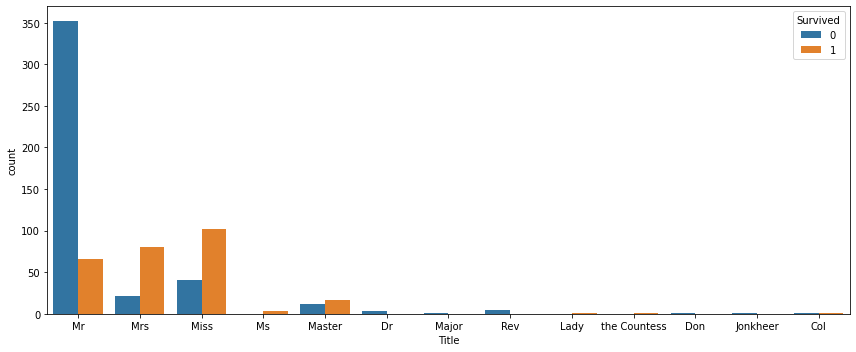

In [63]:
fig,ax = plt.subplots(figsize=(12,5))
sns.countplot(hue='Survived',data=train_set,x='Title',)
plt.tight_layout()

We could also add a feature of Family Size

### Feature - 'SibSp' & 'Parch'

In [64]:
train_set['FamilySize'] = train_set.SibSp +	train_set.Parch
train_set['FamilySize'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([ 0,  2,  3,  4,  1,  5, 10,  7,  6])

We have now extracted information from the features 'Cabin','Ticket' and 'Name' and now we shall drop these columns along with 'PassengerId'.


In [65]:
train_set.drop(['Cabin','Ticket','PassengerId','Name'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
cat_cols_updated = list(cat_cols)
cat_cols_updated.append('Title')
num_cols_updated = list(num_cols)
num_cols_updated.append('FamilySize')

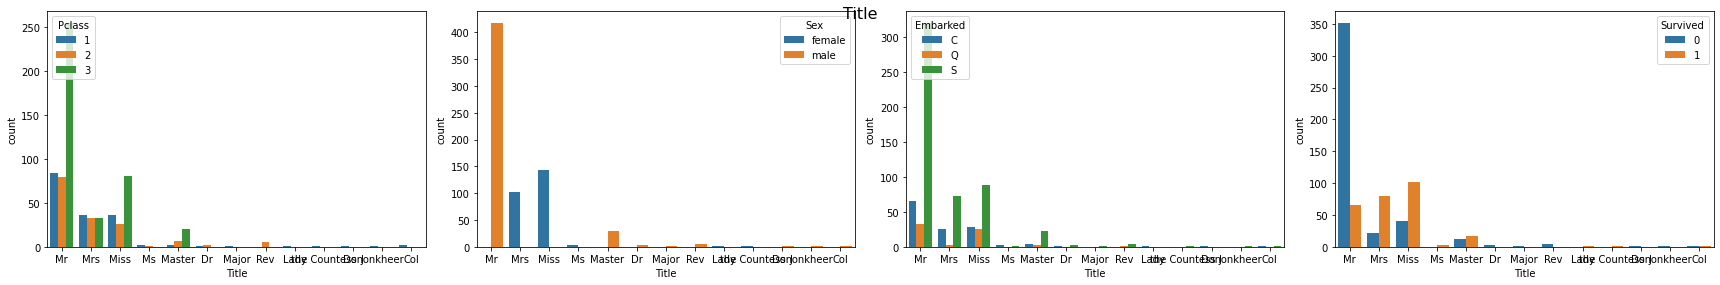

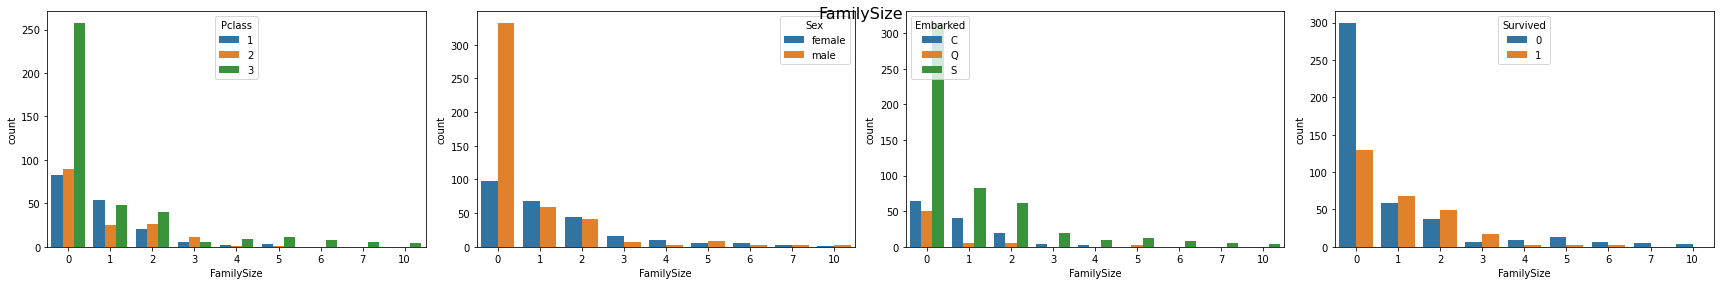

In [67]:
for i,col in enumerate(['Title','FamilySize']):
  j=0
  fig,ax = plt.subplots(1,4,figsize=(24,4),)
  for col1 in ['Pclass','Sex','Embarked','Survived']:
      sns.countplot(x=col,data=train_set,hue=col1,ax=ax[j])
      j=j+1
  
  fig.suptitle(col,size=16)
  fig.tight_layout()

We will create a Custom Transformer to extract/create new features

In [68]:
from sklearn.base import TransformerMixin,BaseEstimator

In [69]:
class FeatureEngineering(TransformerMixin,BaseEstimator):

  def __init__(self):
    self
  
  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):

    X = X.reset_index(drop=True)

    # Creating Feature 'Title'
    X['Title'] = X['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])
    X['Title'] = X['Title'].replace(['Mlle'],['Ms'])

    # Creating Feature 'FamilySize'
    X['FamilySize'] = X.SibSp +	X.Parch


    #cabins=[]
    #cabin_cat = []
    #for x in X.Cabin.value_counts().index:
    #  if ' ' in x:
    #    cabins.extend(x.split(' '))
    #  else:
    #    cabins.append(x)
    #cabin_cat.extend([x[0] for x in cabins])
    for cabin_x in set(cabin_cat):
      X[f'Cabin_{cabin_x}']=[int(cabin_x in str(x)) for x in X.Cabin]

    #shared_cabins = X.Cabin.value_counts()[X.Cabin.value_counts()>1].index
    for cabin_ in shared_cabins:
      X[f'Cabin_shared_{cabin_}']=[int(x==cabin_) for x in X.Cabin]

    #passengers_in_cabin = X.Cabin.value_counts()[X.Cabin.value_counts()>1]
    for n in passengers_in_cabin.unique():
      X[f'{n}_Passenger_Cabin'] =  0
    for index,x in enumerate(X.Cabin):
      if x in passengers_in_cabin.index:
        n = passengers_in_cabin[x]
        X.loc[index,f'{n}_Passenger_Cabin'] =  1


    #ticket_codes=[]
    #for x in X.Ticket.value_counts().index:
    #  if ' ' in x:
    #    ticket_codes.append(x.split(' ')[0])
    #ticket_codes = [x.replace('.','') for x in ticket_codes]
    #ticket_pattern_uniq = pd.Series(ticket_codes).unique()
    for x in ticket_pattern_uniq:
      X['Ticket_'+x] = [int(x == str(y).split(' ')[0].replace('.','')) for y in X.Ticket]

    for ticket_ in shared_tickets.index:
      X[f'Ticket_shared_{ticket_}']=[int(x==ticket_) for x in X.Ticket]

    #shared_tickets = X.Ticket.value_counts()[X.Ticket.value_counts()>1]
    for n in shared_tickets.unique():
      X[f'{n}_Passenger_Ticket'] =  0
    for index,x in enumerate(X.Ticket):
      if x in shared_tickets.index:
        n = shared_tickets[x]
        X.loc[index,f'{n}_Passenger_Ticket'] =  1

    X = X.drop(['PassengerId','Name','Ticket', 'Cabin'],axis=1)

    return X


In [70]:
# A custom transformer to view the data inbetween the various stages of the pipeline
class TransformationSubStage(TransformerMixin,BaseEstimator):

  def __init__(self):
    self
    self.transformed_X = None
    self.transformed_y = None
  
  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    self.transformed_X = X
    self.transformed_y = y
    return X

### Building a Pipeline

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [72]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [73]:
sub_pipe1 = Pipeline([
                      ('imputer',SimpleImputer(strategy='most_frequent')),
                      (('ohe',OneHotEncoder(handle_unknown='ignore')))
])

In [74]:
coltransformer = ColumnTransformer([
                                    ('num_impute',SimpleImputer(strategy='median'),['Age', 'SibSp', 'Parch', 'FamilySize']),
                                    ('num_impute2',SimpleImputer(strategy='mean'),['Fare']),
                                    ('cat_impute',sub_pipe1,['Sex', 'Embarked', 'Pclass', 'Title'])
],remainder='passthrough')

In [75]:
pipe = Pipeline([
                 ('feat_engg',FeatureEngineering()),
                 ('substage_feat_engg',TransformationSubStage()),
                 ('coltransformer',coltransformer),
                 ('substage_coltransformer',TransformationSubStage()),
                 ('num',StandardScaler()),
])

In [76]:
X_train,y_train = clean_data(train_original)
X_train = pipe.fit_transform(X_train)

In [77]:
X_train.shape

(710, 210)

In [78]:
X_test,y_test = clean_data(test_set)
X_test = pipe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [79]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [80]:
from sklearn.metrics import accuracy_score

In [81]:
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV

In [82]:
models = {}

### Logistic Regression

In [83]:
logreg_gridSearch = LogisticRegressionCV(solver='saga',penalty='elasticnet',Cs=[0.1,0.2,0.5,1,10,15,20,25,50,100,100],l1_ratios=[0,0.35,0.5,0.65,1],n_jobs=-1,cv=3,random_state=21)
logreg_gridSearch.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

LogisticRegressionCV(Cs=[0.1, 0.2, 0.5, 1, 10, 15, 20, 25, 50, 100, 100],
                     class_weight=None, cv=3, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=[0, 0.35, 0.5, 0.65, 1],
                     max_iter=100, multi_class='auto', n_jobs=-1,
                     penalty='elasticnet', random_state=21, refit=True,
                     scoring=None, solver='saga', tol=0.0001, verbose=0)

In [84]:
logreg = LogisticRegression(solver='saga',penalty='elasticnet',C=logreg_gridSearch.C_[0],l1_ratio=logreg_gridSearch.l1_ratio_[0],n_jobs=-1,random_state=21)
logreg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.65, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='elasticnet',
                   random_state=21, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
accuracy = accuracy_score(y_test,logreg.predict(X_test))
accuracy

0.8379888268156425

In [86]:
models['Logistic Regression'] = accuracy

### Linear SVC

In [87]:
params ={'C':[0.01,0.1,1,2,5,10,20,50,100,1000],
         'penalty':['l1','l2']}
lin_svc = GridSearchCV(LinearSVC(random_state=21),params)

In [88]:
lin_svc.fit(X_train,y_train)
lin_svc.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-tes

{'C': 0.01, 'penalty': 'l2'}

In [89]:
lin_svc = lin_svc.best_estimator_

In [90]:
accuracy = accuracy_score(y_test,lin_svc.predict(X_test))
accuracy

0.8324022346368715

In [91]:
models['Linear SVC'] = accuracy

### SVC

In [92]:
params ={'C':[0.01,0.1,1,2,5,10,20,50,100,1000],
         'kernel':['rbf','sigmoid']}
svc = GridSearchCV(SVC(random_state=21,probability=True),params)

In [93]:
svc.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=21, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 1000],
                         'kernel': ['rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [94]:
svc.best_params_

{'C': 2, 'kernel': 'sigmoid'}

In [95]:
svc = svc.best_estimator_

In [96]:
accuracy = accuracy_score(y_test,svc.predict(X_test))
accuracy

0.8379888268156425

In [97]:
models['SVC'] = accuracy

### Decision Tree Classifier

In [98]:
dt_clf = DecisionTreeClassifier(random_state=21)
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [99]:
accuracy = accuracy_score(y_test,dt_clf.predict(X_test))
accuracy

0.776536312849162

In [100]:
models['Decision Tree'] = accuracy

### Random Forest Classifier (Ensemble)

In [101]:
!pip install -q optuna

     |████████████████████████████████| 302 kB 5.0 MB/s 
     |████████████████████████████████| 164 kB 75.1 MB/s 
     |████████████████████████████████| 80 kB 9.5 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 111 kB 78.6 MB/s 
     |████████████████████████████████| 141 kB 76.0 MB/s 


In [102]:
import optuna

In [103]:
def objective(trial):

  max_features=trial.suggest_float('max_features',0.3,1,step=0.05)
  max_samples=trial.suggest_float('max_samples',0.3,0.95,step=0.05)
  min_samples_split=trial.suggest_float('min_samples_split',0.01,0.11,step=0.01)
  class_weight=trial.suggest_categorical('class_weight',['balanced', 'balanced_subsample',None])

  print(dict(max_features=max_features, max_samples=max_samples, min_samples_split=min_samples_split,class_weight=class_weight))

  clf = RandomForestClassifier(max_features=max_features, max_samples=max_samples, min_samples_split=min_samples_split,class_weight=class_weight,random_state=21)

  return cross_val_score(clf,X_train,y_train,cv=3,n_jobs=-1,scoring='accuracy').mean()

In [104]:
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=50)

[I 2021-08-25 14:30:29,624] A new study created in memory with name: no-name-8566cb28-ad98-4734-ad3a-7453229260b9


{'max_features': 0.5, 'max_samples': 0.8, 'min_samples_split': 0.09999999999999999, 'class_weight': 'balanced'}


[I 2021-08-25 14:30:31,599] Trial 0 finished with value: 0.8253057283844668 and parameters: {'max_features': 0.5, 'max_samples': 0.8, 'min_samples_split': 0.09999999999999999, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8253057283844668.


{'max_features': 0.5, 'max_samples': 0.6000000000000001, 'min_samples_split': 0.05, 'class_weight': 'balanced_subsample'}


[I 2021-08-25 14:30:32,275] Trial 1 finished with value: 0.8267241173806288 and parameters: {'max_features': 0.5, 'max_samples': 0.6000000000000001, 'min_samples_split': 0.05, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.8267241173806288.


{'max_features': 0.8500000000000001, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:30:33,202] Trial 2 finished with value: 0.8351986936518152 and parameters: {'max_features': 0.8500000000000001, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.4, 'max_samples': 0.4, 'min_samples_split': 0.06999999999999999, 'class_weight': None}


[I 2021-08-25 14:30:33,811] Trial 3 finished with value: 0.812617702448211 and parameters: {'max_features': 0.4, 'max_samples': 0.4, 'min_samples_split': 0.06999999999999999, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.55, 'max_samples': 0.45, 'min_samples_split': 0.08, 'class_weight': None}


[I 2021-08-25 14:30:34,436] Trial 4 finished with value: 0.8083744546949868 and parameters: {'max_features': 0.55, 'max_samples': 0.45, 'min_samples_split': 0.08, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.4, 'max_samples': 0.75, 'min_samples_split': 0.05, 'class_weight': 'balanced'}


[I 2021-08-25 14:30:35,121] Trial 5 finished with value: 0.8295251376671673 and parameters: {'max_features': 0.4, 'max_samples': 0.75, 'min_samples_split': 0.05, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.75, 'max_samples': 0.3, 'min_samples_split': 0.060000000000000005, 'class_weight': None}


[I 2021-08-25 14:30:35,740] Trial 6 finished with value: 0.8097928436911488 and parameters: {'max_features': 0.75, 'max_samples': 0.3, 'min_samples_split': 0.060000000000000005, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.75, 'max_samples': 0.6000000000000001, 'min_samples_split': 0.02, 'class_weight': 'balanced'}


[I 2021-08-25 14:30:36,514] Trial 7 finished with value: 0.8309554458985912 and parameters: {'max_features': 0.75, 'max_samples': 0.6000000000000001, 'min_samples_split': 0.02, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.95, 'max_samples': 0.45, 'min_samples_split': 0.03, 'class_weight': None}


[I 2021-08-25 14:30:37,247] Trial 8 finished with value: 0.8168430713485423 and parameters: {'max_features': 0.95, 'max_samples': 0.45, 'min_samples_split': 0.03, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 1.0, 'max_samples': 0.45, 'min_samples_split': 0.02, 'class_weight': 'balanced'}


[I 2021-08-25 14:30:37,989] Trial 9 finished with value: 0.8182733795799662 and parameters: {'max_features': 1.0, 'max_samples': 0.45, 'min_samples_split': 0.02, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8500000000000001, 'max_samples': 0.95, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:30:38,961] Trial 10 finished with value: 0.8239171374764594 and parameters: {'max_features': 0.8500000000000001, 'max_samples': 0.95, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.7, 'max_samples': 0.65, 'min_samples_split': 0.03, 'class_weight': None}


[I 2021-08-25 14:30:39,721] Trial 11 finished with value: 0.8196858089584973 and parameters: {'max_features': 0.7, 'max_samples': 0.65, 'min_samples_split': 0.03, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8, 'max_samples': 0.95, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:30:40,685] Trial 12 finished with value: 0.8239230970940904 and parameters: {'max_features': 0.8, 'max_samples': 0.95, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.9000000000000001, 'max_samples': 0.6000000000000001, 'min_samples_split': 0.04, 'class_weight': None}


[I 2021-08-25 14:30:41,484] Trial 13 finished with value: 0.8112410307754655 and parameters: {'max_features': 0.9000000000000001, 'max_samples': 0.6000000000000001, 'min_samples_split': 0.04, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.65, 'max_samples': 0.75, 'min_samples_split': 0.03, 'class_weight': None}


[I 2021-08-25 14:30:42,267] Trial 14 finished with value: 0.8239111778588285 and parameters: {'max_features': 0.65, 'max_samples': 0.75, 'min_samples_split': 0.03, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:30:43,160] Trial 15 finished with value: 0.8295430165200601 and parameters: {'max_features': 0.8, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.6000000000000001, 'max_samples': 0.65, 'min_samples_split': 0.11, 'class_weight': None}


[I 2021-08-25 14:30:43,871] Trial 16 finished with value: 0.8069739445517176 and parameters: {'max_features': 0.6000000000000001, 'max_samples': 0.65, 'min_samples_split': 0.11, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.7, 'max_samples': 0.55, 'min_samples_split': 0.04, 'class_weight': None}


[I 2021-08-25 14:30:44,597] Trial 17 finished with value: 0.8112350711578346 and parameters: {'max_features': 0.7, 'max_samples': 0.55, 'min_samples_split': 0.04, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.3, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.08, 'class_weight': None}


[I 2021-08-25 14:30:45,248] Trial 18 finished with value: 0.8196679301056045 and parameters: {'max_features': 0.3, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.08, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.9000000000000001, 'max_samples': 0.7, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:30:46,119] Trial 19 finished with value: 0.8267479558511527 and parameters: {'max_features': 0.9000000000000001, 'max_samples': 0.7, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 1.0, 'max_samples': 0.55, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:30:46,945] Trial 20 finished with value: 0.8210922787193974 and parameters: {'max_features': 1.0, 'max_samples': 0.55, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8500000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:30:47,880] Trial 21 finished with value: 0.8337922238909151 and parameters: {'max_features': 0.8500000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:30:48,706] Trial 22 finished with value: 0.8253295668549906 and parameters: {'max_features': 0.8, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.9000000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:30:49,648] Trial 23 finished with value: 0.8337803046556532 and parameters: {'max_features': 0.9000000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.9000000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.04, 'class_weight': None}


[I 2021-08-25 14:30:50,459] Trial 24 finished with value: 0.8211041979546593 and parameters: {'max_features': 0.9000000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.04, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8500000000000001, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.03, 'class_weight': None}


[I 2021-08-25 14:30:51,277] Trial 25 finished with value: 0.8309614055162221 and parameters: {'max_features': 0.8500000000000001, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.03, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.95, 'max_samples': 0.8, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:30:52,206] Trial 26 finished with value: 0.8281544256120528 and parameters: {'max_features': 0.95, 'max_samples': 0.8, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.95, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:30:53,199] Trial 27 finished with value: 0.8267479558511527 and parameters: {'max_features': 0.95, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8500000000000001, 'max_samples': 0.75, 'min_samples_split': 0.05, 'class_weight': None}


[I 2021-08-25 14:30:54,046] Trial 28 finished with value: 0.818285298815228 and parameters: {'max_features': 0.8500000000000001, 'max_samples': 0.75, 'min_samples_split': 0.05, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.75, 'max_samples': 0.8, 'min_samples_split': 0.03, 'class_weight': None}


[I 2021-08-25 14:30:54,882] Trial 29 finished with value: 0.8239171374764594 and parameters: {'max_features': 0.75, 'max_samples': 0.8, 'min_samples_split': 0.03, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.65, 'max_samples': 0.95, 'min_samples_split': 0.09, 'class_weight': None}


[I 2021-08-25 14:30:55,677] Trial 30 finished with value: 0.8154723592934278 and parameters: {'max_features': 0.65, 'max_samples': 0.95, 'min_samples_split': 0.09, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8500000000000001, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.03, 'class_weight': None}


[I 2021-08-25 14:30:56,486] Trial 31 finished with value: 0.8309614055162221 and parameters: {'max_features': 0.8500000000000001, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.03, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8500000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:30:57,297] Trial 32 finished with value: 0.8323857541300151 and parameters: {'max_features': 0.8500000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.9000000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:30:58,244] Trial 33 finished with value: 0.8337803046556532 and parameters: {'max_features': 0.9000000000000001, 'max_samples': 0.8500000000000001, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 1.0, 'max_samples': 0.8, 'min_samples_split': 0.04, 'class_weight': None}


[I 2021-08-25 14:30:59,055] Trial 34 finished with value: 0.8211161171899212 and parameters: {'max_features': 1.0, 'max_samples': 0.8, 'min_samples_split': 0.04, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.9000000000000001, 'max_samples': 0.7, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:30:59,926] Trial 35 finished with value: 0.8337981835085461 and parameters: {'max_features': 0.9000000000000001, 'max_samples': 0.7, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.95, 'max_samples': 0.7, 'min_samples_split': 0.060000000000000005, 'class_weight': None}


[I 2021-08-25 14:31:00,767] Trial 36 finished with value: 0.8140599299148966 and parameters: {'max_features': 0.95, 'max_samples': 0.7, 'min_samples_split': 0.060000000000000005, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8, 'max_samples': 0.7, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:31:01,625] Trial 37 finished with value: 0.8351927340341844 and parameters: {'max_features': 0.8, 'max_samples': 0.7, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.7, 'max_samples': 0.7, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:31:02,452] Trial 38 finished with value: 0.8323738348947533 and parameters: {'max_features': 0.7, 'max_samples': 0.7, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.75, 'max_samples': 0.55, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:31:03,138] Trial 39 finished with value: 0.8281603852296837 and parameters: {'max_features': 0.75, 'max_samples': 0.55, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.45, 'max_samples': 0.75, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:31:03,884] Trial 40 finished with value: 0.8281365467591599 and parameters: {'max_features': 0.45, 'max_samples': 0.75, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8, 'max_samples': 0.7, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:31:04,719] Trial 41 finished with value: 0.8211101575722902 and parameters: {'max_features': 0.8, 'max_samples': 0.7, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.9000000000000001, 'max_samples': 0.75, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:31:05,625] Trial 42 finished with value: 0.81970368781139 and parameters: {'max_features': 0.9000000000000001, 'max_samples': 0.75, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.95, 'max_samples': 0.8, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:31:06,550] Trial 43 finished with value: 0.8281544256120528 and parameters: {'max_features': 0.95, 'max_samples': 0.8, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8, 'max_samples': 0.65, 'min_samples_split': 0.03, 'class_weight': None}


[I 2021-08-25 14:31:07,254] Trial 44 finished with value: 0.8210922787193974 and parameters: {'max_features': 0.8, 'max_samples': 0.65, 'min_samples_split': 0.03, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.8500000000000001, 'max_samples': 0.95, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:31:08,225] Trial 45 finished with value: 0.8239171374764594 and parameters: {'max_features': 0.8500000000000001, 'max_samples': 0.95, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.75, 'max_samples': 0.4, 'min_samples_split': 0.02, 'class_weight': None}


[I 2021-08-25 14:31:08,904] Trial 46 finished with value: 0.8196500512527116 and parameters: {'max_features': 0.75, 'max_samples': 0.4, 'min_samples_split': 0.02, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.9000000000000001, 'max_samples': 0.5, 'min_samples_split': 0.06999999999999999, 'class_weight': None}


[I 2021-08-25 14:31:09,627] Trial 47 finished with value: 0.8111993134520489 and parameters: {'max_features': 0.9000000000000001, 'max_samples': 0.5, 'min_samples_split': 0.06999999999999999, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 0.55, 'max_samples': 0.8, 'min_samples_split': 0.05, 'class_weight': None}


[I 2021-08-25 14:31:10,390] Trial 48 finished with value: 0.8140599299148966 and parameters: {'max_features': 0.55, 'max_samples': 0.8, 'min_samples_split': 0.05, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


{'max_features': 1.0, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.01, 'class_weight': None}


[I 2021-08-25 14:31:11,423] Trial 49 finished with value: 0.8281544256120528 and parameters: {'max_features': 1.0, 'max_samples': 0.9000000000000001, 'min_samples_split': 0.01, 'class_weight': None}. Best is trial 2 with value: 0.8351986936518152.


In [105]:
best_trial = study.best_trial
print("Accuracy : ",best_trial.value)
best_trial.params

Accuracy :  0.8351986936518152


{'class_weight': None,
 'max_features': 0.8500000000000001,
 'max_samples': 0.9000000000000001,
 'min_samples_split': 0.02}

In [106]:
rf_clf = RandomForestClassifier(**best_trial.params,random_state=21)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None,
                       max_features=0.8500000000000001, max_leaf_nodes=None,
                       max_samples=0.9000000000000001,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.02,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [107]:
accuracy = accuracy_score(y_test,rf_clf.predict(X_test))
accuracy

0.7988826815642458

In [108]:
models['Random Forest'] = accuracy

### K-Nearest Neighbor Classifier

In [109]:
params = {'n_neighbors' : [2,3,4,5,6,7,8,9,10]}
knn_clf = GridSearchCV(KNeighborsClassifier(), params)

In [110]:
knn_clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [111]:
knn_clf.best_params_

{'n_neighbors': 5}

In [112]:
accuracy = accuracy_score(y_test,knn_clf.predict(X_test))
accuracy

0.7932960893854749

In [113]:
models['K-Nearest Neighbor'] = accuracy

### Gaussian Naive Bayes Classifier

In [114]:
params = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_clf = GridSearchCV(GaussianNB(), params)

In [115]:
nb_clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02,...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [116]:
nb_clf.best_params_

{'var_smoothing': 0.0657933224657568}

In [117]:
accuracy = accuracy_score(y_test,nb_clf.predict(X_test))
accuracy

0.659217877094972

In [118]:
models['Gaussian Naive Bayes'] = accuracy

In [119]:
from sklearn.metrics import SCORERS,accuracy_score
SCORERS

{'accuracy': make_scorer(accuracy_score),
 'adjusted_mutual_info_score': make_scorer(adjusted_mutual_info_score),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'balanced_accuracy': make_scorer(balanced_accuracy_score),
 'completeness_score': make_scorer(completeness_score),
 'explained_variance': make_scorer(explained_variance_score),
 'f1': make_scorer(f1_score, average=binary),
 'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
 'f1_micro': make_scorer(f1_score, pos_label=None, average=micro),
 'f1_samples': make_scorer(f1_score, pos_label=None, average=samples),
 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted),
 'fowlkes_mallows_score': make_scorer(fowlkes_mallows_score),
 'homogeneity_score': make_scorer(homogeneity_score),
 'jaccard': make_scorer(jaccard_score, average=binary),
 'jaccard_macro': make_scorer(jaccard_score, pos_label=None, average=mac

In [120]:
import xgboost as xgb

In [121]:
cv = cross_val_score(xgb.XGBClassifier(random_state =1),X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82394366 0.8028169  0.85915493 0.82394366 0.79577465]
0.8211267605633804


In [122]:
tst = xgb.XGBClassifier(random_state =1).fit(X_train,y_train)
accuracy_score(y_test,tst.predict(X_test))

0.8100558659217877

In [123]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [124]:
n_iter = []
def objective_xgb(trial):

  params = {
      'learning_rate' : trial.suggest_loguniform('learning_rate',1e-8,0.5),
      'max_depth' : trial.suggest_int('max_depth',8,33),
      'subsample' : trial.suggest_float('subsample',0.5,1),
      'colsample_bynode' : trial.suggest_float('colsample_bynode',0.5,1),
      'lambda' : trial.suggest_loguniform("lambda", 1e-8, 1.0),
      'alpha': trial.suggest_loguniform("alpha", 1e-8, 1.0),
      'gamma' : trial.suggest_loguniform("gamma", 1e-8, 1.0),
                
      'objective':'binary:logistic','n_estimators':1000,'random_state':21
  }
  
  dtrain = xgb.DMatrix(X_train,y_train)


  cv = xgb.cv(params, dtrain, metrics='auc', early_stopping_rounds=50)
  n_iter.append(len(cv))

  return cv.mean()['test-auc-mean']

In [125]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb,n_trials=1000)

[I 2021-08-25 14:31:17,856] A new study created in memory with name: no-name-ba16c848-2be8-4a07-8e1f-9172d8ea513f
[I 2021-08-25 14:31:18,128] Trial 0 finished with value: 0.8452011666666668 and parameters: {'learning_rate': 0.0040922607409408325, 'max_depth': 28, 'subsample': 0.8557924689871133, 'colsample_bynode': 0.8842831948101171, 'lambda': 0.000838582900208942, 'alpha': 5.201009069815057e-07, 'gamma': 0.0457122597286987}. Best is trial 0 with value: 0.8452011666666668.
[I 2021-08-25 14:31:18,341] Trial 1 finished with value: 0.8615811666666667 and parameters: {'learning_rate': 0.023239045048789552, 'max_depth': 29, 'subsample': 0.952094764284687, 'colsample_bynode': 0.6618740923758506, 'lambda': 0.245330748080901, 'alpha': 1.3012789715641733e-06, 'gamma': 2.906450430828023e-05}. Best is trial 1 with value: 0.8615811666666667.
[I 2021-08-25 14:31:18,586] Trial 2 finished with value: 0.8496406999999999 and parameters: {'learning_rate': 1.4313027344237485e-06, 'max_depth': 30, 'subsa

In [126]:
best_trial = study.best_trial
print("Accuracy : ",best_trial.value)
best_trial.params

Accuracy :  0.8791458999999999


{'alpha': 0.5027680882795551,
 'colsample_bynode': 0.6441919601896177,
 'gamma': 0.001026556060551002,
 'lambda': 3.1307593794212247e-06,
 'learning_rate': 5.723474027290272e-06,
 'max_depth': 8,
 'subsample': 0.786492408911023}

In [127]:
n_iter[best_trial.number]

10

In [128]:
xgb_clf = xgb.XGBClassifier(**best_trial.params,n_estimators=n_iter[best_trial.number],random_state=21)
xgb_clf

XGBClassifier(alpha=0.5027680882795551, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=0.6441919601896177,
              colsample_bytree=1, gamma=0.001026556060551002,
              lambda=3.1307593794212247e-06,
              learning_rate=5.723474027290272e-06, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=10,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.786492408911023, verbosity=1)

In [129]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(alpha=0.5027680882795551, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=0.6441919601896177,
              colsample_bytree=1, gamma=0.001026556060551002,
              lambda=3.1307593794212247e-06,
              learning_rate=5.723474027290272e-06, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=10,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.786492408911023, verbosity=1)

In [130]:
accuracy = accuracy_score(y_test,xgb_clf.predict(X_test))
accuracy

0.8268156424581006

In [131]:
models['XGBoost'] = accuracy

In [132]:
models

{'Decision Tree': 0.776536312849162,
 'Gaussian Naive Bayes': 0.659217877094972,
 'K-Nearest Neighbor': 0.7932960893854749,
 'Linear SVC': 0.8324022346368715,
 'Logistic Regression': 0.8379888268156425,
 'Random Forest': 0.7988826815642458,
 'SVC': 0.8379888268156425,
 'XGBoost': 0.8268156424581006}

### AdaBoost Classifier (Ensemble)

In [133]:
adaboost_base = AdaBoostClassifier(random_state=21)
adaboost_base.fit(X_train,y_train)
accuracy = accuracy_score(y_test,adaboost_base.predict(X_test))
accuracy

0.8324022346368715

In [134]:
def objective_adaboost(trial):

  params = {
      'n_estimators':trial.suggest_int('n_estimators',2,200),
      'learning_rate' : trial.suggest_loguniform('learning_rate',1e-6,0.5)
  }

  clf = AdaBoostClassifier(**params,random_state=21)

  cv_score = cross_val_score(clf,X_train, y_train , scoring='accuracy', cv=3, n_jobs=-1,)

  return cv_score.mean()

In [135]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_adaboost,200)

[I 2021-08-25 14:35:01,521] A new study created in memory with name: no-name-db34287f-0c93-4acf-b874-940453bbd936
[I 2021-08-25 14:35:02,028] Trial 0 finished with value: 0.7886957972776466 and parameters: {'n_estimators': 55, 'learning_rate': 0.00025610226362851655}. Best is trial 0 with value: 0.7886957972776466.
[I 2021-08-25 14:35:02,288] Trial 1 finished with value: 0.7886957972776466 and parameters: {'n_estimators': 18, 'learning_rate': 1.3053756866525696e-05}. Best is trial 0 with value: 0.7886957972776466.
[I 2021-08-25 14:35:02,721] Trial 2 finished with value: 0.7886957972776466 and parameters: {'n_estimators': 45, 'learning_rate': 3.614825521040974e-05}. Best is trial 0 with value: 0.7886957972776466.
[I 2021-08-25 14:35:03,453] Trial 3 finished with value: 0.792915206560347 and parameters: {'n_estimators': 87, 'learning_rate': 0.006548112203351686}. Best is trial 3 with value: 0.792915206560347.
[I 2021-08-25 14:35:04,011] Trial 4 finished with value: 0.7886957972776466 and

In [136]:
best_trial = study.best_trial
best_trial.params

{'learning_rate': 0.19801308976546725, 'n_estimators': 135}

In [137]:
adaboost_clf = AdaBoostClassifier(**best_trial.params,random_state=21).fit(X_train,y_train)
accuracy = accuracy_score(y_test,adaboost_clf.predict(X_test))
accuracy
# 0.8379888268156425

0.8324022346368715

In [138]:
models['AdaBoost Classifier'] = accuracy
models

{'AdaBoost Classifier': 0.8324022346368715,
 'Decision Tree': 0.776536312849162,
 'Gaussian Naive Bayes': 0.659217877094972,
 'K-Nearest Neighbor': 0.7932960893854749,
 'Linear SVC': 0.8324022346368715,
 'Logistic Regression': 0.8379888268156425,
 'Random Forest': 0.7988826815642458,
 'SVC': 0.8379888268156425,
 'XGBoost': 0.8268156424581006}

### Voting Classifier (Ensemble)

In [139]:
votting_clf = VotingClassifier([('Linear SVC',lin_svc),('Logistic Regression',logreg),('SVC',svc),('Random Forest',rf_clf),('K-Nearest Neighbor',knn_clf)],n_jobs=-1)
votting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('Linear SVC',
                              LinearSVC(C=0.01, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=21, tol=0.0001,
                                        verbose=0)),
                             ('Logistic Regression',
                              LogisticRegression(C=0.1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_r...
                                           estimator=KNeighborsClassifier(algorithm='auto',
                                                                          leaf_size=30,
         

In [140]:
accuracy = accuracy_score(y_test,votting_clf.predict(X_test))
accuracy
# 0.8324022346368715

0.8268156424581006

In [141]:
votting_clf2 = VotingClassifier([('Logistic Regression',logreg),('SVC',svc),('Random Forest',rf_clf),('K-Nearest Neighbor',knn_clf)],voting='soft',n_jobs=-1)
votting_clf2.fit(X_train,y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=0.1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=0.65, max_iter=100,
                                                 multi_class='auto', n_jobs=-1,
                                                 penalty='elasticnet',
                                                 random_state=21, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('SVC',
                              SVC(C=2, break_ties=False, cache_size=200,
                                  class_weight...
                                           estimator=KNeighborsClassifier(algorithm='auto',
                  

In [142]:
accuracy = accuracy_score(y_test,votting_clf2.predict(X_test))
accuracy
# 0.8379888268156425

0.8324022346368715

In [143]:
votting_clf3 = VotingClassifier([('SVC',svc),('AdaBoost',adaboost_clf),('XGBoost',xgb_clf),],voting='soft',n_jobs=-1)
votting_clf3.fit(X_train,y_train)

VotingClassifier(estimators=[('SVC',
                              SVC(C=2, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='sigmoid', max_iter=-1,
                                  probability=True, random_state=21,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('AdaBoost',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=0.198...
                                            lambda=3.1307593794212247e-06,
                                            learning_rate=5.723474027290272e-06,
                                            max_delta_step=0, max_depth=8,
                                       

In [144]:
accuracy = accuracy_score(y_test,votting_clf3.predict(X_test))
accuracy
# 0.8379888268156425

0.8379888268156425

In [145]:
test_data_raw.shape

(418, 11)

In [146]:
test_data_raw.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [147]:
X_test_data = clean_data(test_data_raw)
X_test_data = pipe.transform(X_test_data)

In [161]:
svc_result = svc.predict(X_test_data).astype(int)
vot_clf1_result = votting_clf.predict(X_test_data).astype(int)
vot_clf2_result = votting_clf2.predict(X_test_data).astype(int)
vot_clf3_result = votting_clf3.predict(X_test_data).astype(int)

In [159]:
sub_data = {'PassengerId': test_data_raw.PassengerId, 'Survived': svc_result}
submission = pd.DataFrame(data=sub_data)
submission.to_csv('submission_svc.csv', index =False)

In [149]:
sub_data = {'PassengerId': test_data_raw.PassengerId, 'Survived': vot_clf1_result}
submission = pd.DataFrame(data=sub_data)
submission.to_csv('submission_vot_clf1.csv', index =False)

In [151]:
sub_data = {'PassengerId': test_data_raw.PassengerId, 'Survived': vot_clf2_result}
submission = pd.DataFrame(data=sub_data)
submission.to_csv('submission_vot_clf2.csv', index =False)

In [162]:
sub_data = {'PassengerId': test_data_raw.PassengerId, 'Survived': vot_clf3_result}
submission = pd.DataFrame(data=sub_data)
submission.to_csv('submission_vot_clf3.csv', index =False)

In [164]:
#!kaggle competitions submit -c titanic -f submission_svc.csv -m "SVC"

100% 2.77k/2.77k [00:00<00:00, 13.1kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

For the particular data, **SVM classifier** with the Sigmoid kernal is the most ideal model

In [165]:
svc

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=True, random_state=21, shrinking=True, tol=0.001,
    verbose=False)